
# A Low Poly Art Tutorial in Python

So I thought we should try and do something a bit creative and visual so this isn't too much of a bore. So how about turning images into low poly art. This is a simplified [verison](https://cosmiccoding.com.au/tutorials/lowpoly) of an existing tutorial I wrote, so if you want something a tiny bit more advanced, feel free to get a few more details in that link.

Feel free to upload your own image and do something that you find personally interesting, just upload it and then replace swap out the `bg1.jpg` for whatever your image is called.

In [1]:
input_image = "bg1.jpg"
output_image = "lowpoly.png"

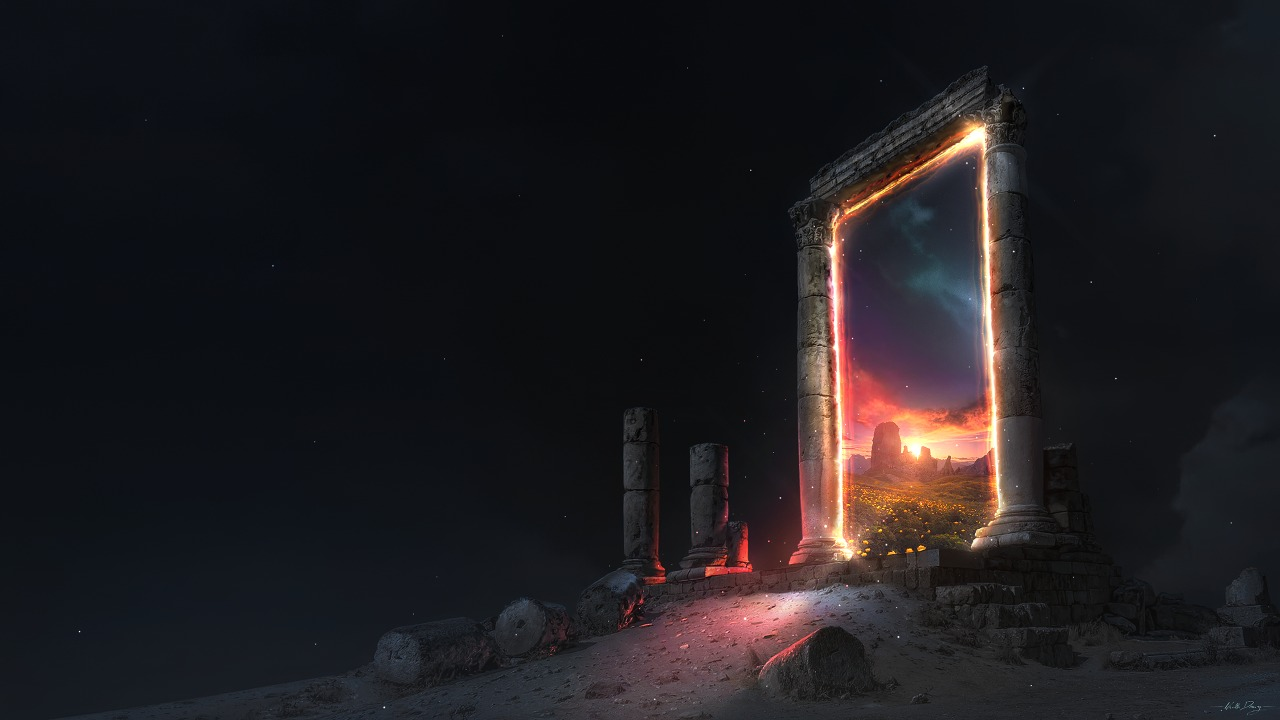

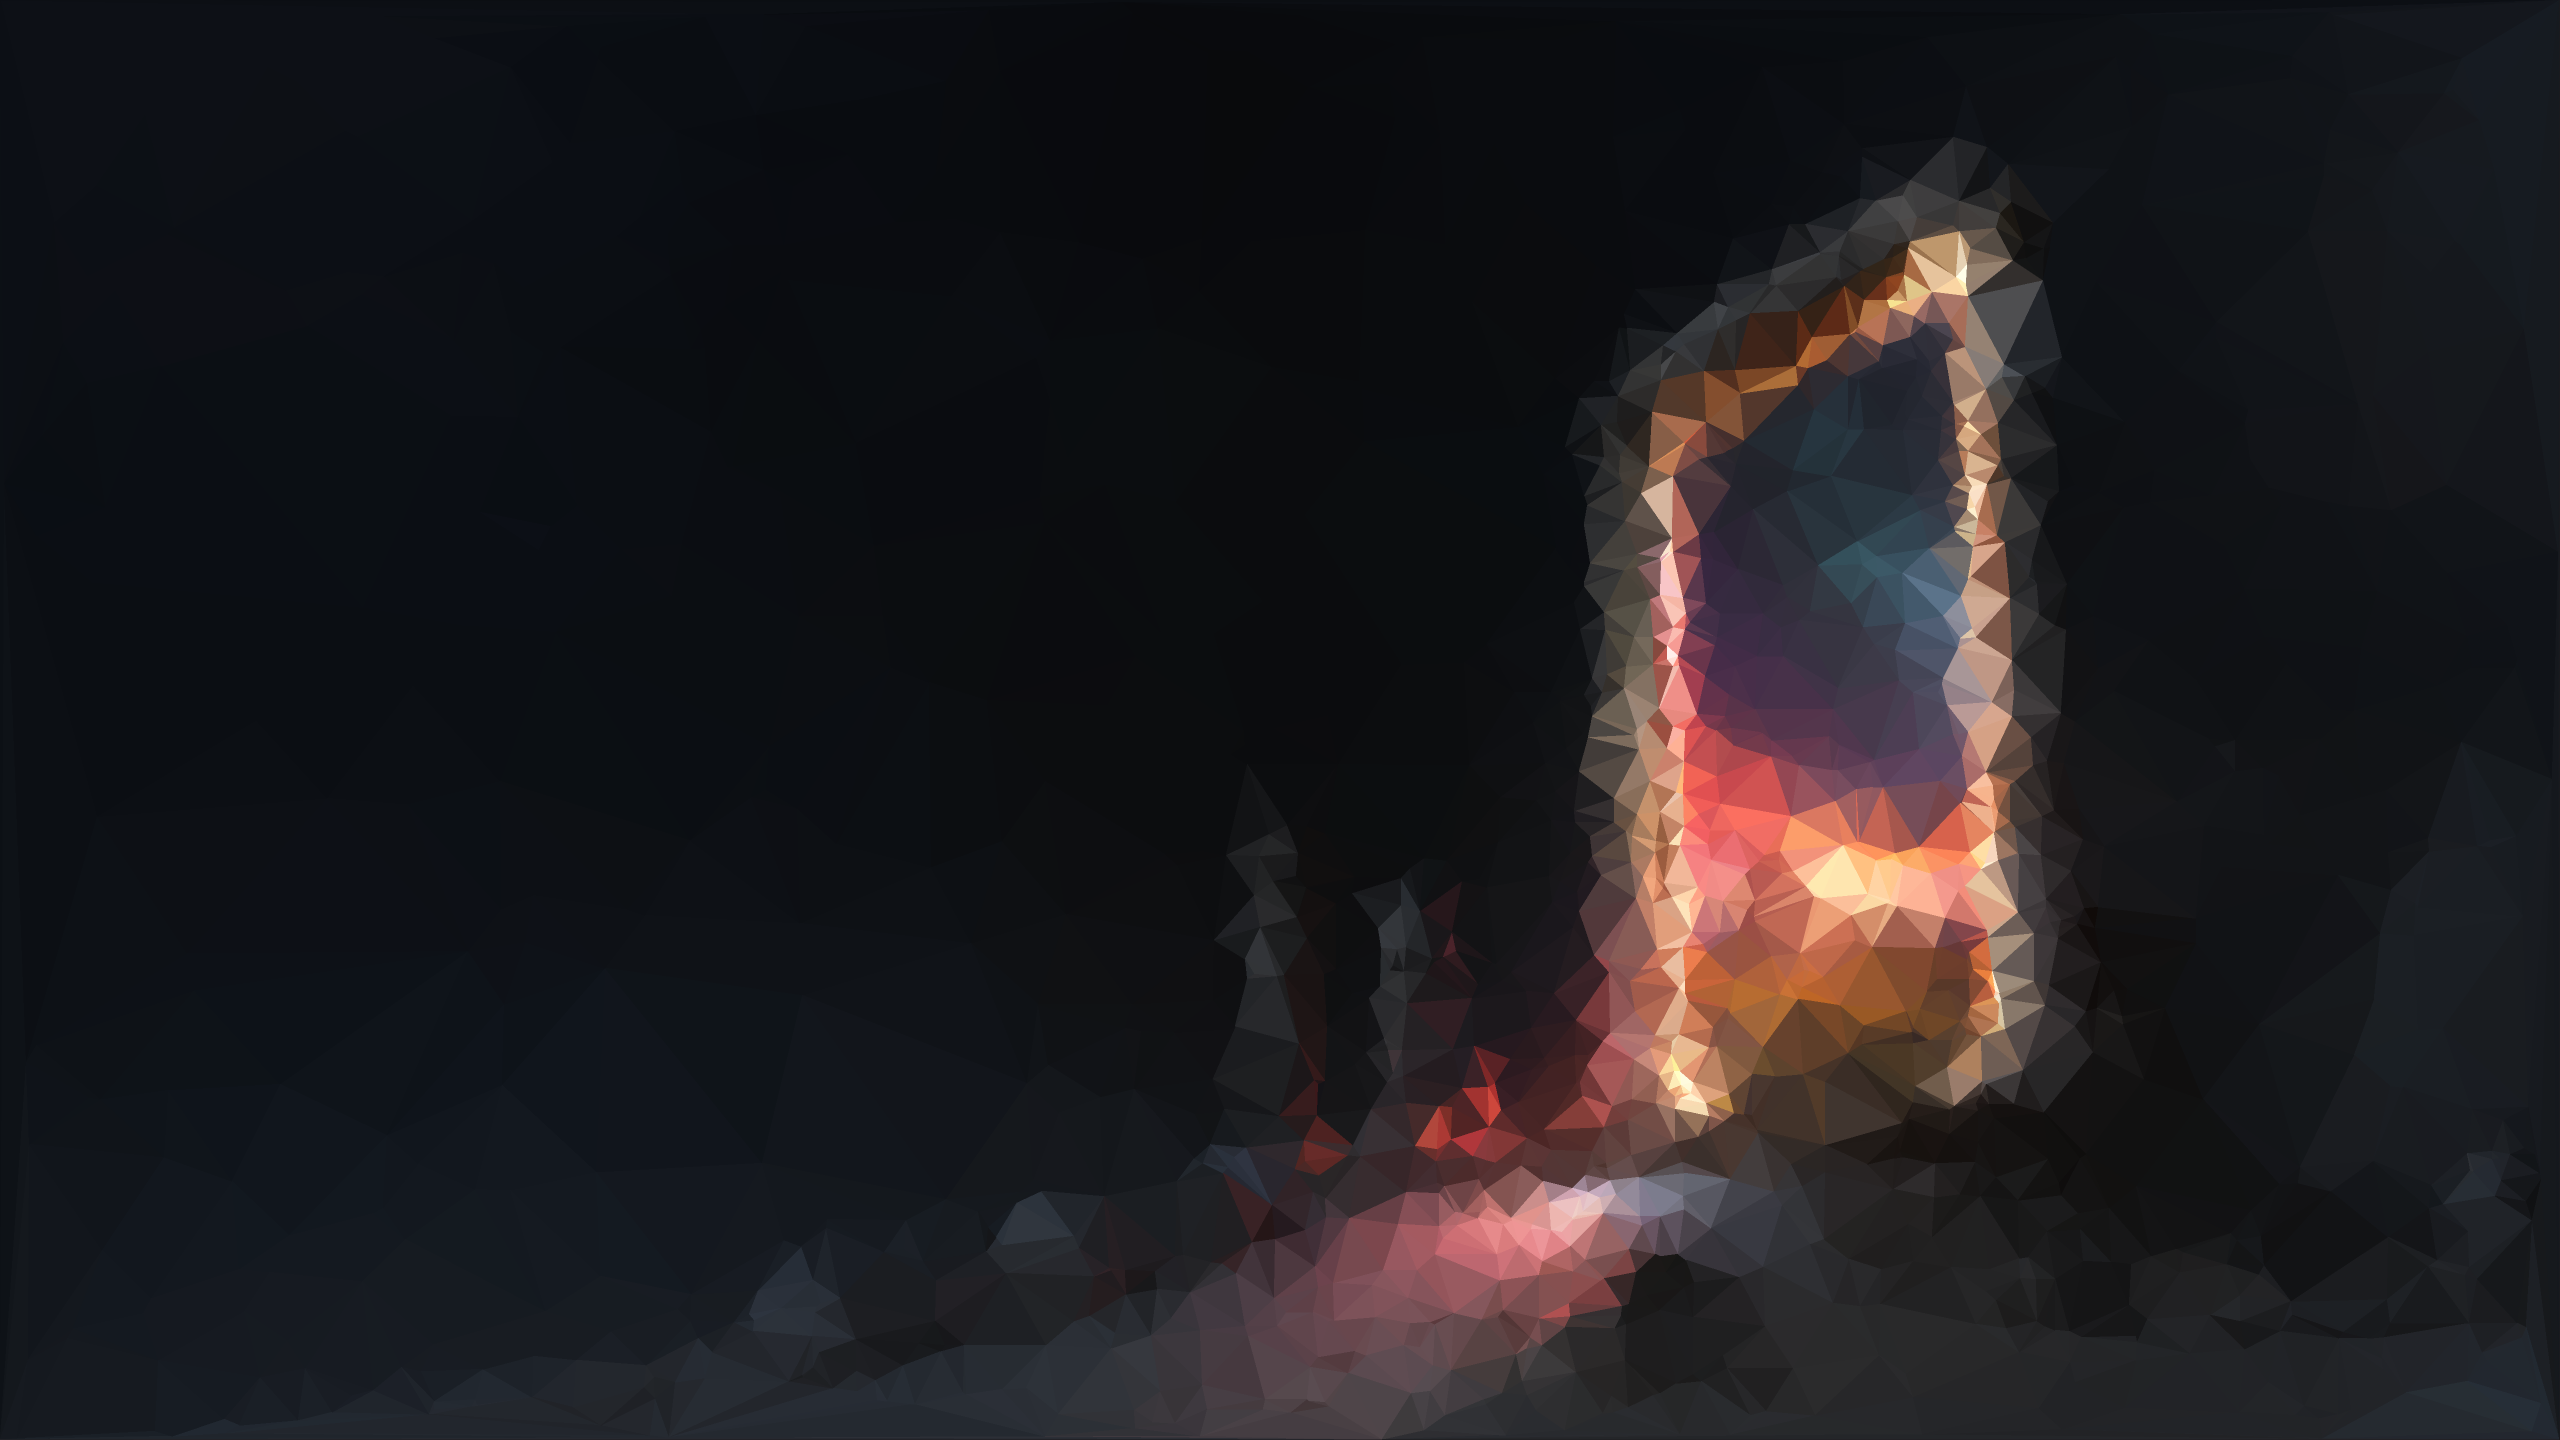

In [2]:
from IPython.display import Image, Video
display(Image(input_image), Image(output_image))

We've only got about half an hour, so let's keep this simple.

The basic steps we'll follow are:

1. Load our image in
2. Draw verticies in our image
3. Calculate triangles from vertices
4. Determine the colour of the triangles
5. Plot the image

Lets get our imports out of the way and then power through each section:

In [3]:
import numpy as np
import pygame
import pygame.gfxdraw
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from collections import defaultdict
import ignoreme  # my own file with some defaults

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1. Load in Our Image

First step is to get the image into memory. We'll use pygame to load this into an array (`matplotlib` could also do this). And then I want to turn the image to grayscale so we can work with 2D and not 3D data. However, human eyes are not equally sensitive to all colours, so we don't want a standard mean of the red, green, and blue components. Looking at the [Wikipedia page for Luma](https://en.wikipedia.org/wiki/Luma_(video)), there are a few options, but I'm going to pick the first one on the page which states that:

$$ Y = 0.2126R + 0.7152G + 0.0722B $$

Who know that blue counted for so little? In the first run through I'm going to use an image of a portal which has a very distinct area of detail and a larger area of lower detail to highlight what we're doing. Then at the very end I'll run the code for other images too and see what we get!


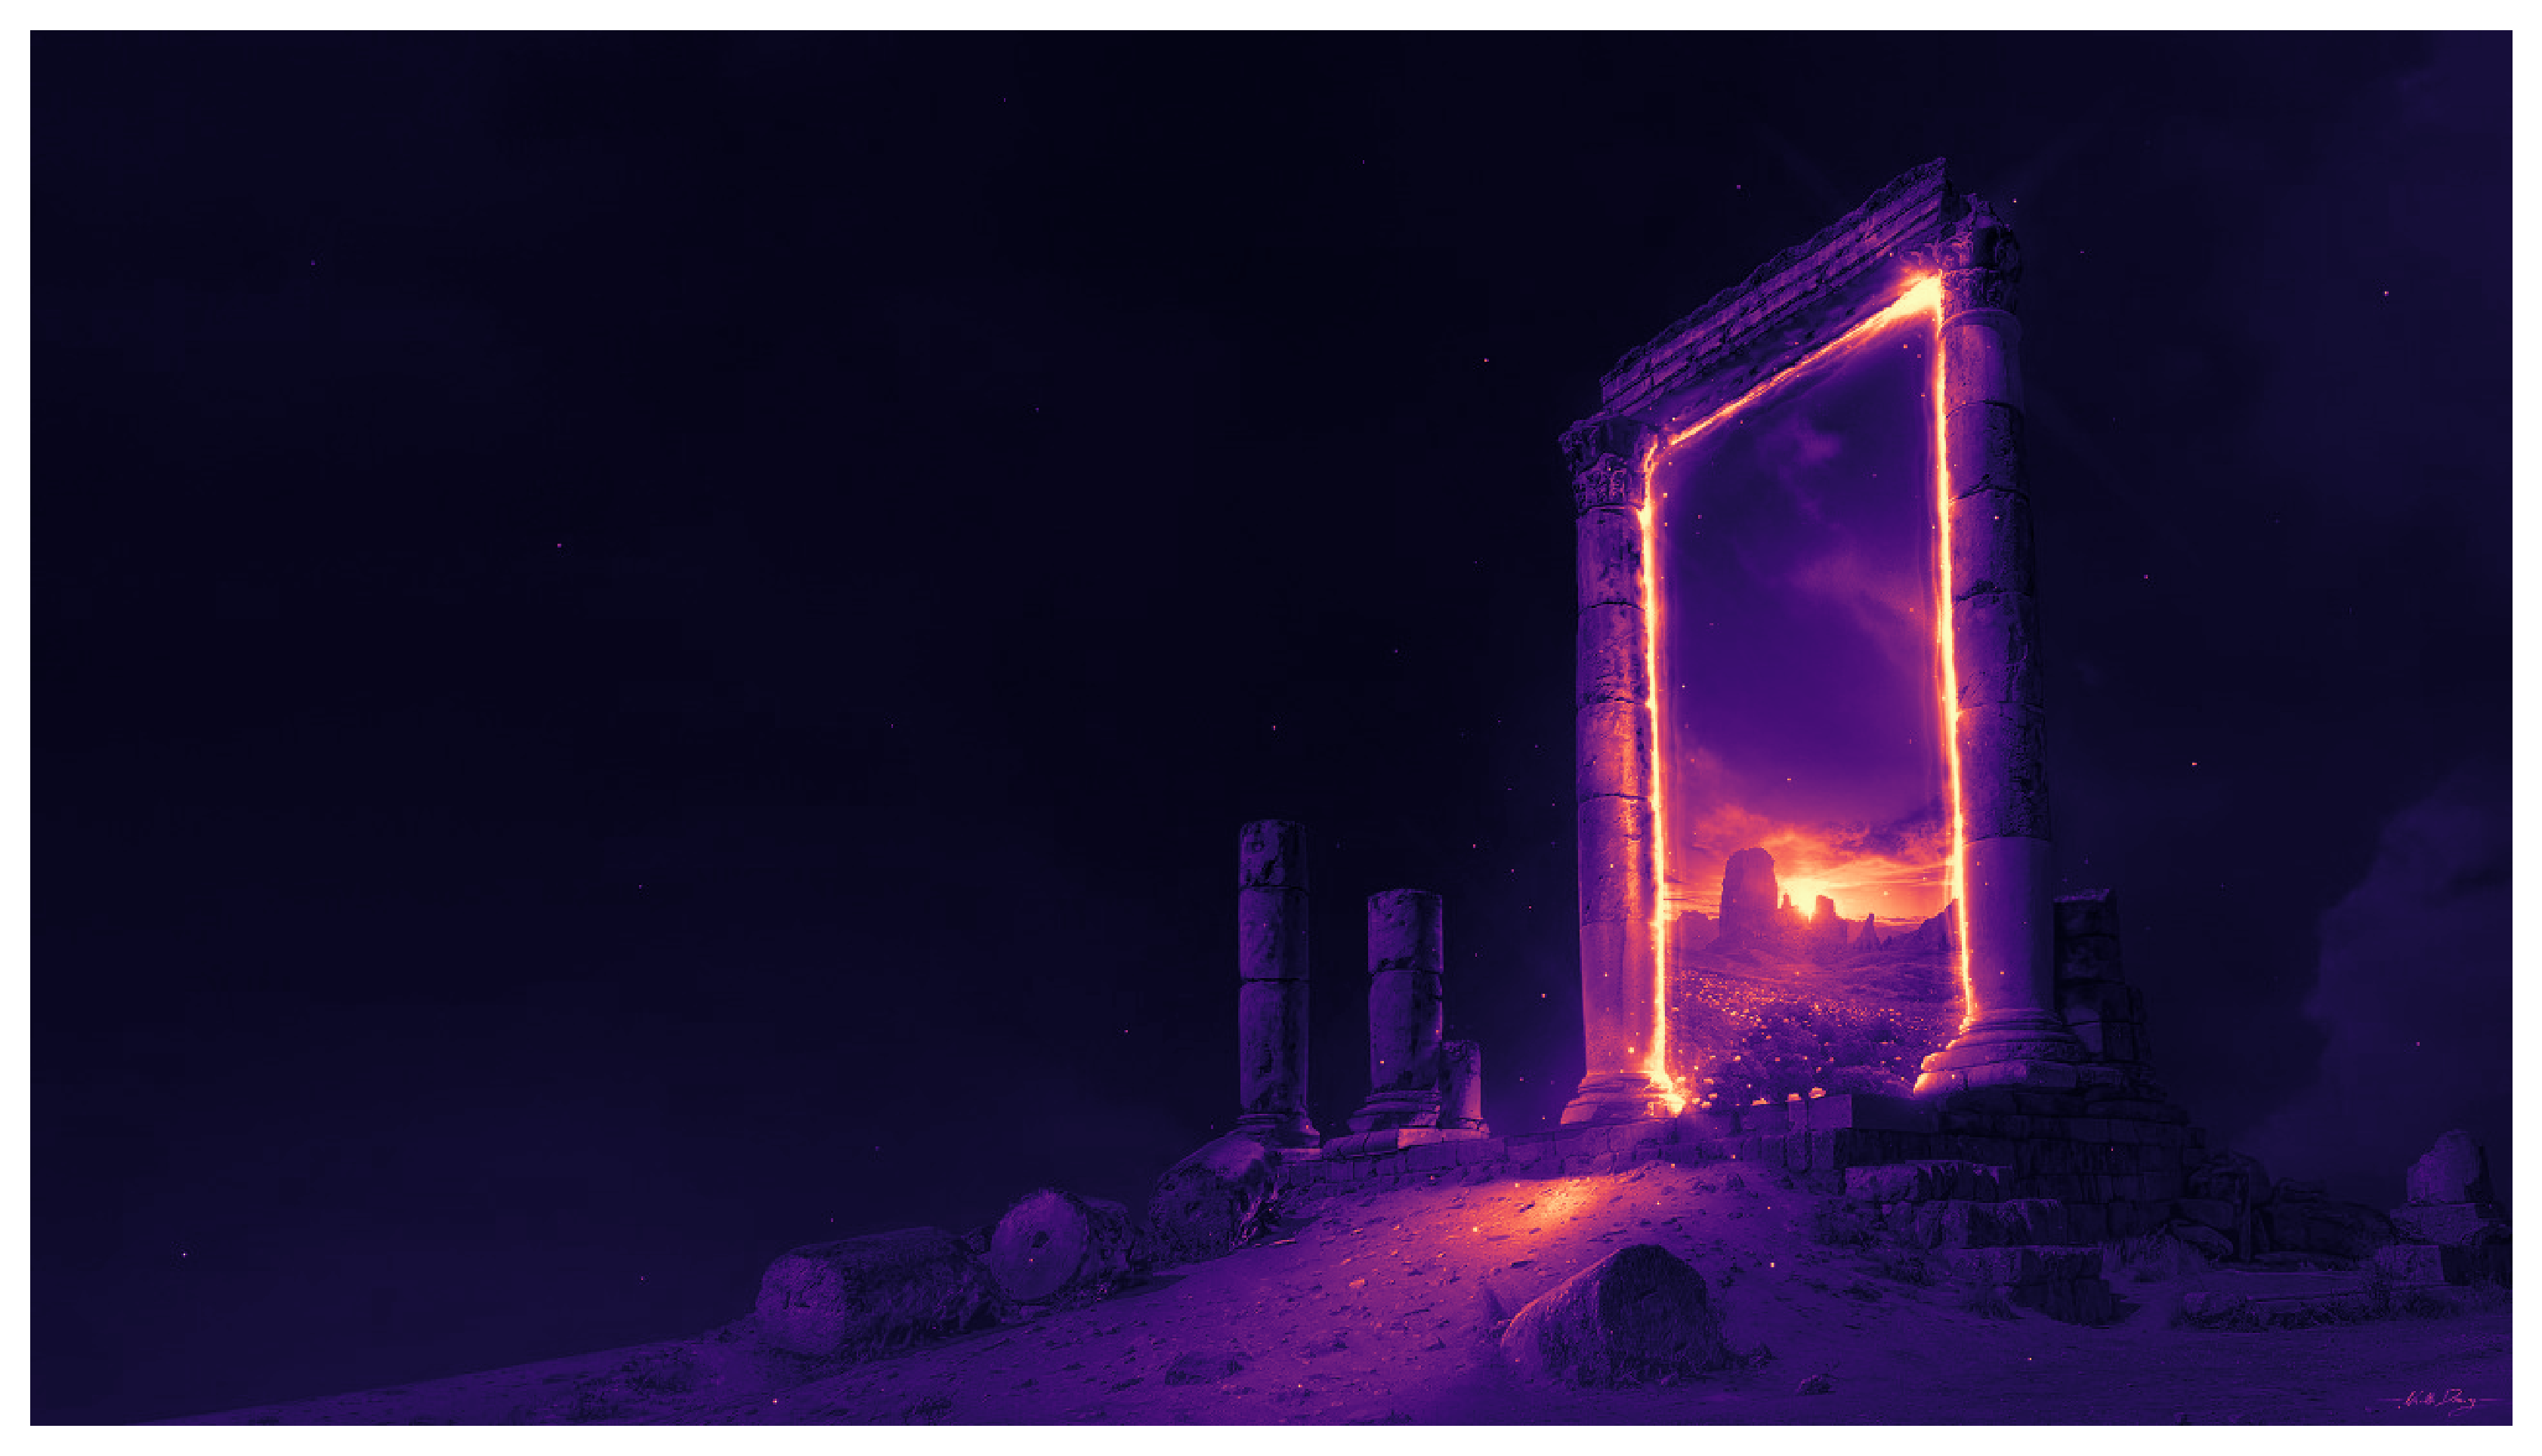

In [4]:
inp = pygame.surfarray.pixels3d(pygame.image.load(input_image))
perceptual_weight = np.array([0.2126, 0.7152, 0.0722])
grayscale = (inp * perceptual_weight).sum(axis=-1)
grayscale = grayscale / grayscale.max()
plt.imshow(grayscale.T);

## 2. Draw points in the image

Great, our image is now nice and flat. We *could* use this if we wanted to sample points according to how luminous the image.

To do this, we'll use [rejection sampling](https://cosmiccoding.com.au/tutorials/rejection_sampling), which means we pick a random $x, y$ coordinate and accept or reject it based upon whether a random uniform number is below the luminosity at that point. So the higher the luminosity, the greater the chance to accept it. We'll also generate a buttload of points to start with and just take what we need from that list.

So here is a nice function which takes a reference image and returns sample points and their value:


In [6]:
def sample(ref, n=100000):
    np.random.seed(0)
    w, h = ref.shape
    xs = np.random.randint(0, w, size=n)
    ys = np.random.randint(0, h, size=n)
    value = ref[xs, ys]
    accept = np.random.random(size=n) < value
    points = np.array([xs[accept], ys[accept]])
    return points.T, value[accept]

samples, v = sample(grayscale)
print(samples.shape)

(11623, 2)


Let's plot these points to see if they look nicely distributed:

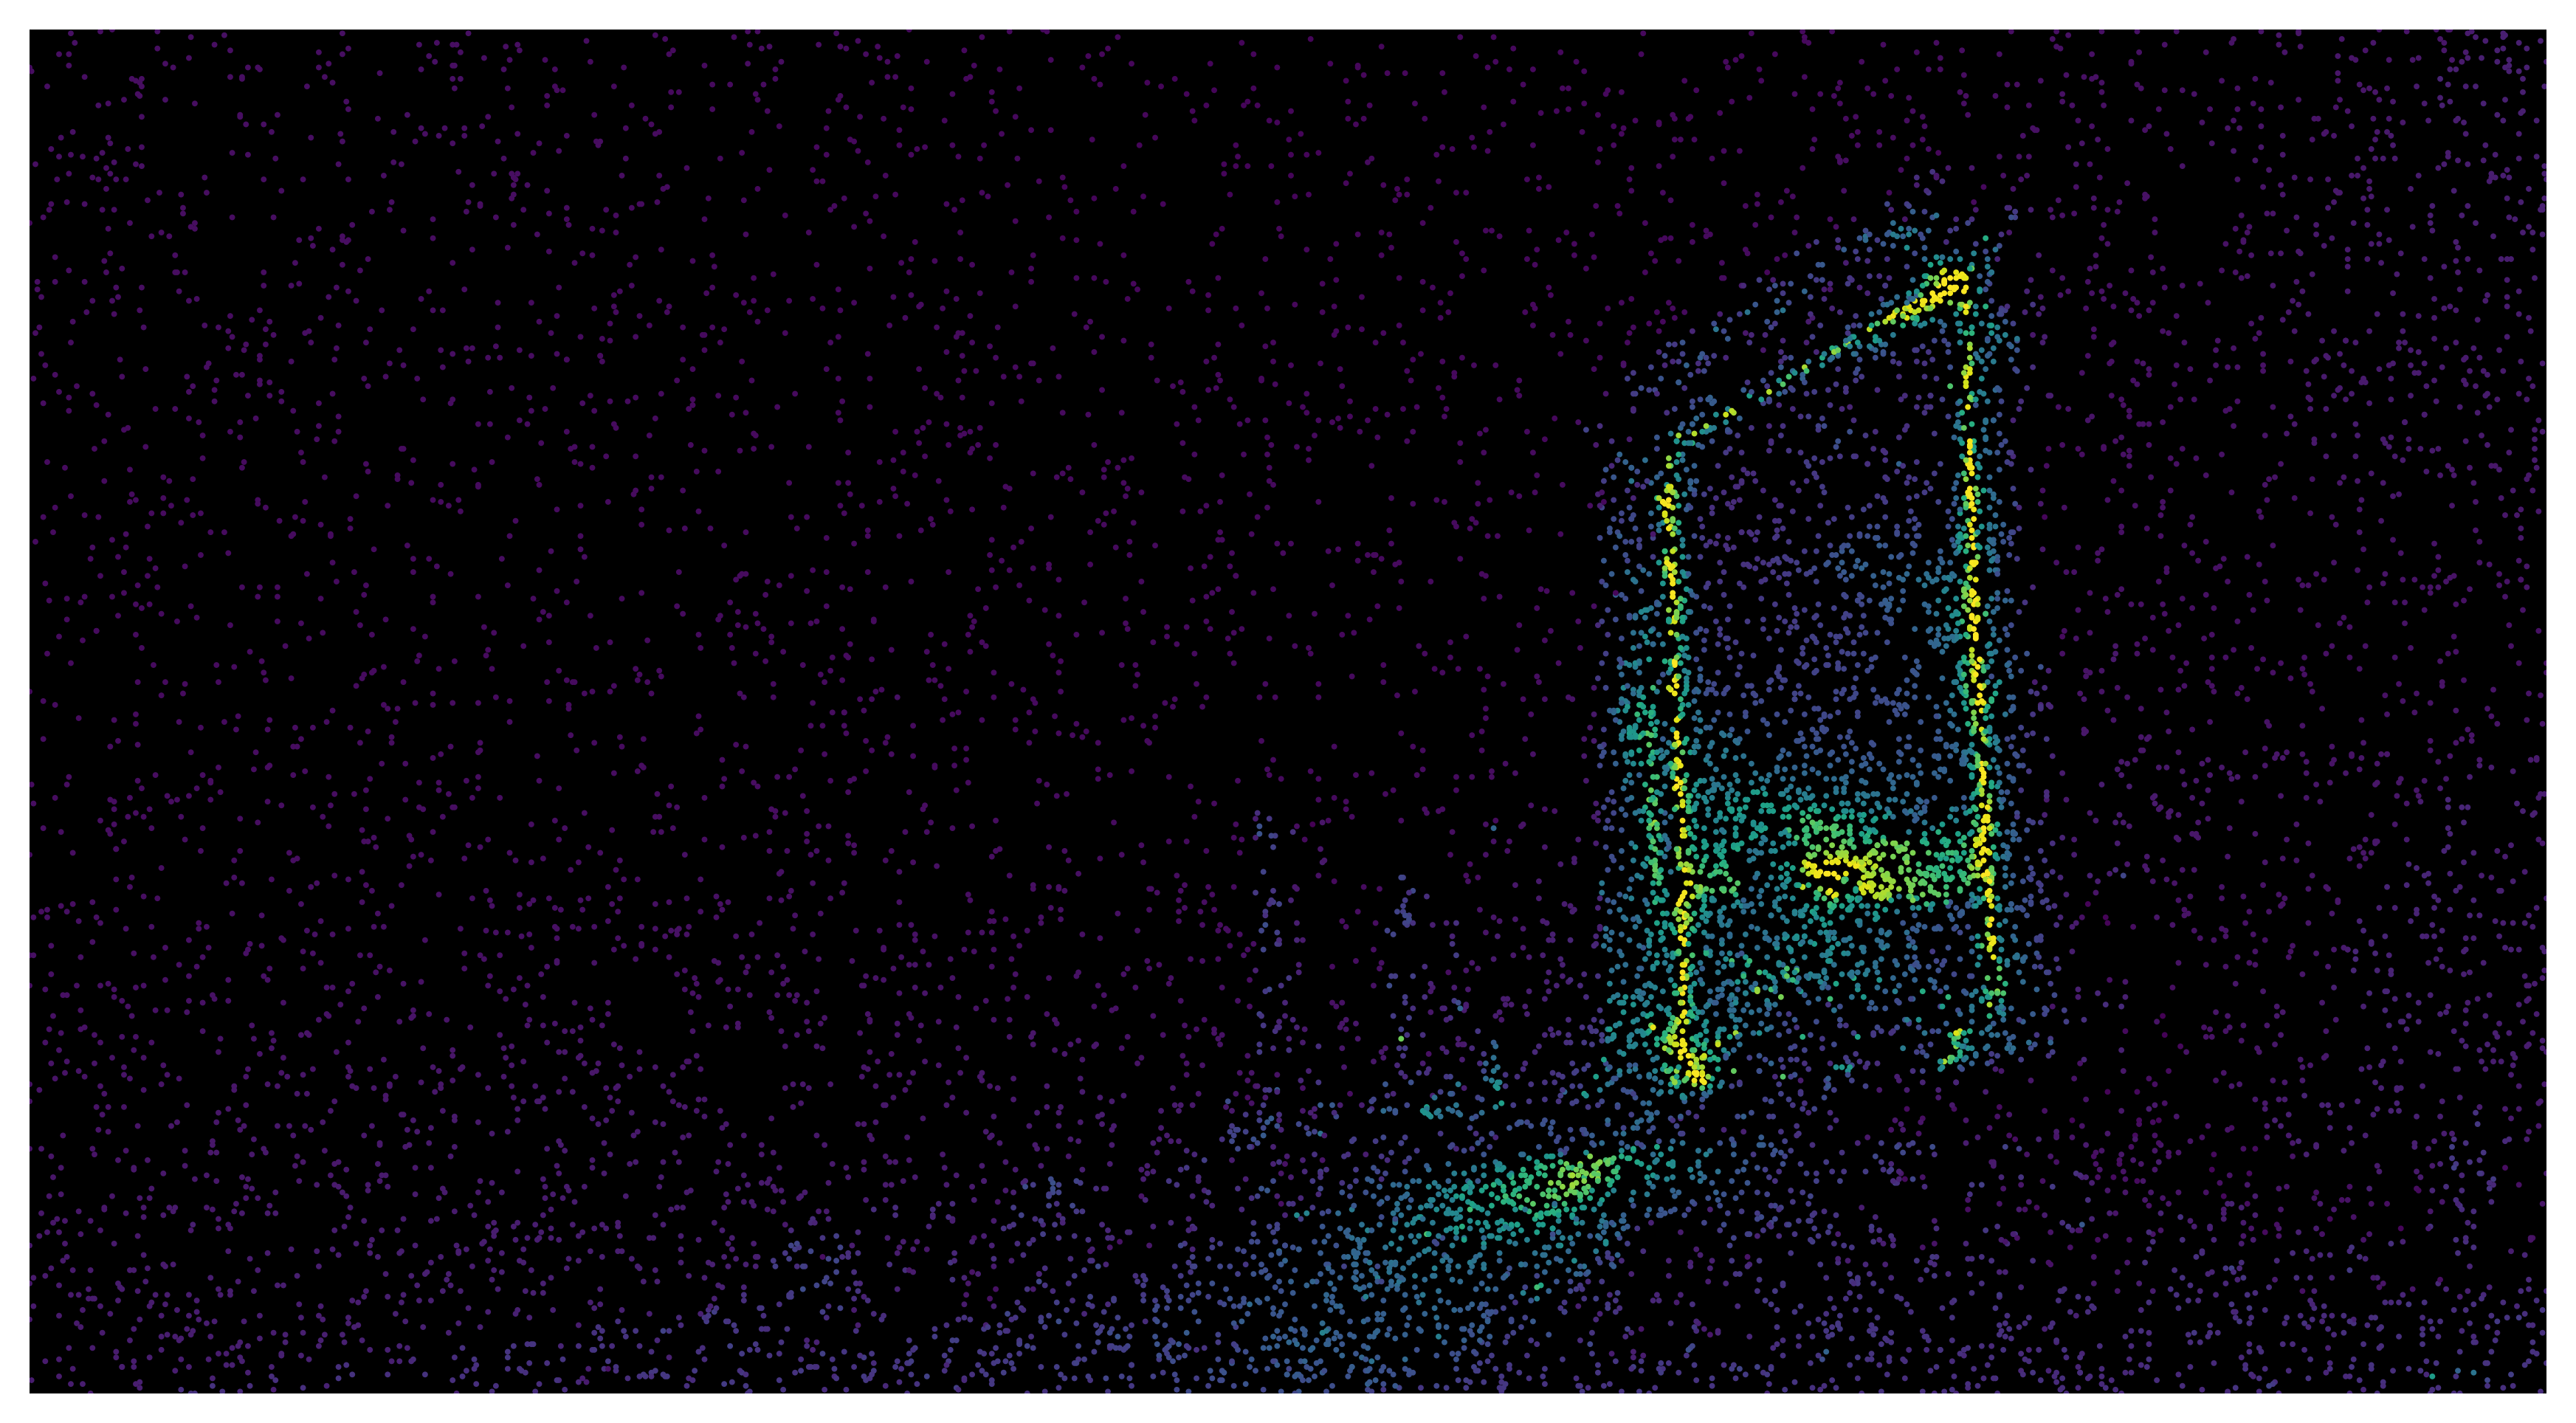

In [10]:
plt.scatter(samples[:, 0], -samples[:, 1], c=v, s=2, edgecolors="none", cmap="viridis")
plt.gca().set_facecolor("k"), plt.margins(0);

Looks good to me!

## 4. Triangles from vertices

This is actually super simple, because `scipy` has done it all for us. We'll simply use `Delaunay` triangulation, which you can read more about [here](https://en.wikipedia.org/wiki/Delaunay_triangulation). The TL;DR is that Delaunay triangular is a way of drawing triangles between verticies, such that no external points lie within each triangles circumcircle.

## 5. Colour from triangles

The algorithm is simple. We assign each pixel to a triangle, and then take all the pixels in a triangle and average the colour. Simple... but incredibly slow.

In [11]:
def get_colour_of_tri(tri, image):
    colours = defaultdict(lambda: [])
    w, h, _ = image.shape
    for i in range(0, w, 4):
        for j in range(0, h, 4):
            # Gets the index of the triangle the point is in
            index = tri.find_simplex((i, j))
            colours[int(index)].append(inp[i, j, :])
    # For each triangle, find the average colour
    for index, array in colours.items():
        colours[index] = np.array(array).mean(axis=0)
    return colours

## 6. Plot the image

This function is pretty simple too. We take a screen, and then for each triangle, we use `pygame.gfxdraw` for anti-aliased drawing. I'm plotting the outline and the fill both to try and make sure there are no black gaps between images (but I'm unsure if this actually makes a difference).

In [12]:
def draw(tri, colours, screen):
    s = screen.copy()
    for key, c in colours.items():
        t = tri.points[tri.simplices[key]]
        pygame.gfxdraw.filled_polygon(s, t, c)
    return s

## Putting it all together

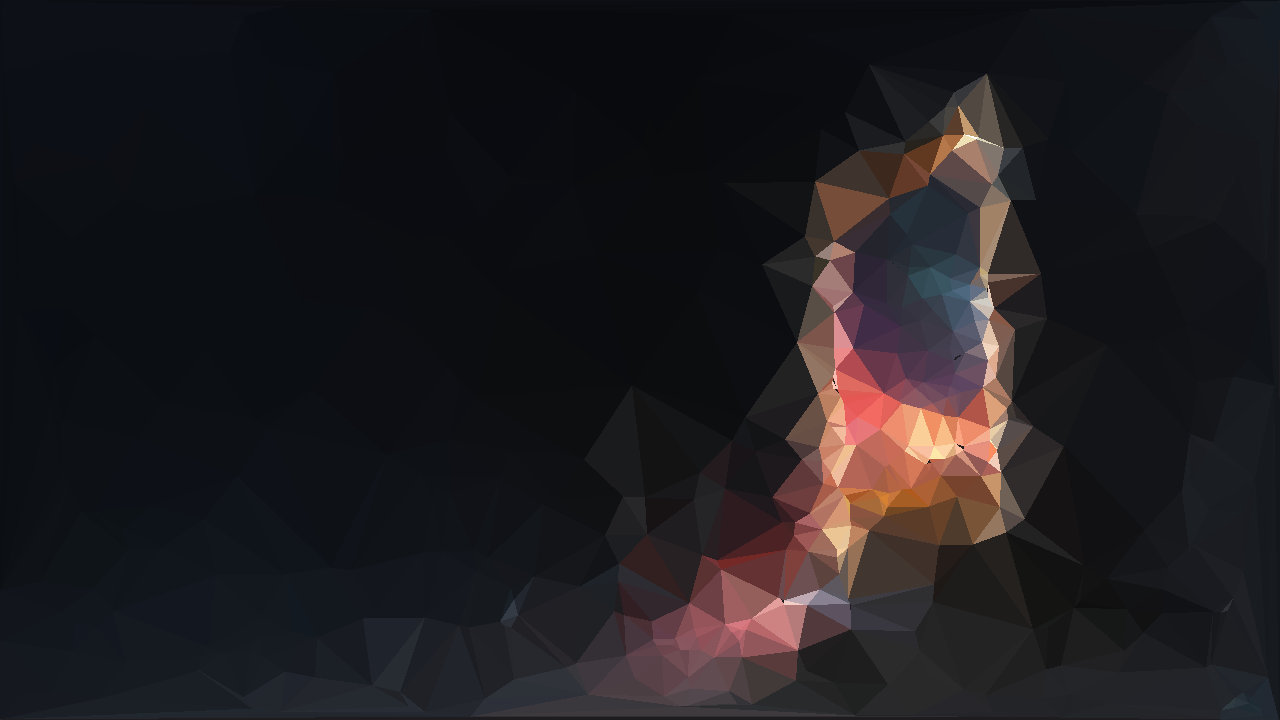

In [14]:
w, h, _ = inp.shape
screen = pygame.Surface((w, h))
screen.fill(inp.mean(axis=(0, 1)))
corners = np.array([(0, 0), (0, h - 1), (w - 1, 0), (w - 1, h - 1)])
points = np.concatenate((corners, samples))

n = 500
tri = Delaunay(points[:n, :])
colours = get_colour_of_tri(tri, inp)
s = draw(tri, colours, screen)

fname = f"{n:04d}.png"
pygame.image.save(s, fname)
Image(fname)

Running this save an image out in the notebook folder. You could even do this for a whole bunch of images, and turn it into an animation using a tool like `ffmpeg`. There are other things that we could improve, like how we draw the random points, and drawing the image at a higher resolution so it doesn't have all that aliasing. Another day!

In [15]:
Video("final1.mp4", width=900)